This notebook analyzes a sample of the dataset to get a rough idea about the range of ratings, genres, and movie titles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

### Load datasets

In [2]:
def load_movies_dataset(n_rows = 10000):
    
    path = '/media/vincent/harddrive/Movielens_data/ml-25m/'
    
    movie_data = pd.read_csv(
        path + 'movies.csv',
        encoding = "ISO-8859-1", 
        nrows = n_rows
    )
    movie_data['movie_title'] = movie_data['title']
    
    return movie_data[['movieId','movie_title','genres']]

def load_ratings(n_rows = 10000):
    
    path = '/media/vincent/harddrive/Movielens_data/ml-25m/'
    
    ratings_data = pd.read_csv(
        path + 'ratings.csv',
        encoding = "ISO-8859-1",
        nrows = n_rows
    )
    #get rid of timestamp column:
    return ratings_data[['userId', 'movieId', 'rating']]


def load_ratings_with_name():
    ratings_data = load_ratings()
    movies_data = load_movies_dataset()
    ratings_data['userId'] = ratings_data['userId'].map(lambda k: f"User_{k}")
    
    ratings_and_movies = ratings_data \
        .set_index('movieId') \
        .join(movies_data['movie_title']) \
        .reset_index()
    
    return ratings_and_movies[['userId', 'movie_title', 'rating']]

In [3]:
#load data
ratings_data = load_ratings()
movies_data = load_movies_dataset()
movie_ratings_df = load_ratings_with_name()

In [4]:
ratings_data.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [5]:
movies_data.head()

,movieId,movie_title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movie_ratings_df.head()

,userId,movie_title,rating
0,User_2,Jumanji (1995),3.5
1,User_3,Jumanji (1995),4.0
2,User_4,Jumanji (1995),3.0
3,User_5,Jumanji (1995),4.0
4,User_8,Jumanji (1995),4.0


### check for missings

In [7]:
movie_ratings_df[movie_ratings_df['movie_title'].isna()].head()

,userId,movie_title,rating
7986,User_43,NaN,3.5
7987,User_12,NaN,4.0
7988,User_70,NaN,3.5
7989,User_46,NaN,4.0
7990,User_58,NaN,4.0


In [8]:
movie_ratings_df[movie_ratings_df['movie_title'].isna()].shape

(2014, 3)

In [9]:
#drop NAs
movie_ratings_df.dropna(inplace=True)
movie_ratings_df.shape

(7986, 3)

### analyze genres

#### get unique genres

In [10]:
genre_help_df = movies_data['genres'].str.split('|', expand = True)
genre_help_df.head()

,0,1,2,3,4,5,6,7
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None
1,Adventure,Children,Fantasy,None,None,None,None,None
2,Comedy,Romance,None,None,None,None,None,None
3,Comedy,Drama,Romance,None,None,None,None,None
4,Comedy,None,None,None,None,None,None,None


In [11]:
genre_help_df[genre_help_df[7].notnull()]

,0,1,2,3,4,5,6,7
4912,Adventure,Comedy,Crime,Drama,Fantasy,Mystery,Sci-Fi,Thriller
8571,Adventure,Animation,Children,Comedy,Drama,Fantasy,Musical,Romance


In [12]:
#get all unique genres:
for i in range(genre_help_df.shape[1]):
    if i < 1:
        set_init = set(genre_help_df[i].unique())
        continue
    else:
        set_help = set(genre_help_df[i].unique())
        
    set_all = set_init.union(set_help)
    
    set_init = set_all
 

#list of unique genres:
uniq_genres = list(set_all)
print(uniq_genres)

#delete "None" entry:
del_idx = uniq_genres.index(None)
del uniq_genres[del_idx]

['Fantasy', 'War', 'Thriller', 'Film-Noir', 'Sci-Fi', 'Musical', 'Children', 'Mystery', 'Western', 'Animation', 'Horror', 'Crime', 'Drama', 'IMAX', 'Adventure', 'Documentary', 'Comedy', None, 'Romance', 'Action']


#### add genre columns

In [13]:
#create new column for each genre:
for genre in uniq_genres:
    
    movies_data[genre] = movies_data['genres'].str.contains(genre).replace(False, 0)

movies_data.head()

,movieId,movie_title,genres,Fantasy,War,Thriller,Film-Noir,Sci-Fi,Musical,Children,...,Animation,Horror,Crime,Drama,IMAX,Adventure,Documentary,Comedy,Romance,Action
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### plot genre counts

In [14]:
sum_genres = movies_data.iloc[:,3:].sum(axis = 0, skipna = True) 
sum_genres.sort_values()

IMAX             34.0
Film-Noir       131.0
Animation       247.0
Western         258.0
Documentary     420.0
Musical         435.0
War             472.0
Children        486.0
Fantasy         490.0
Mystery         535.0
Sci-Fi          716.0
Adventure       940.0
Horror          953.0
Crime          1123.0
Action         1358.0
Thriller       1579.0
Romance        1689.0
Comedy         3464.0
Drama          5057.0
dtype: float64

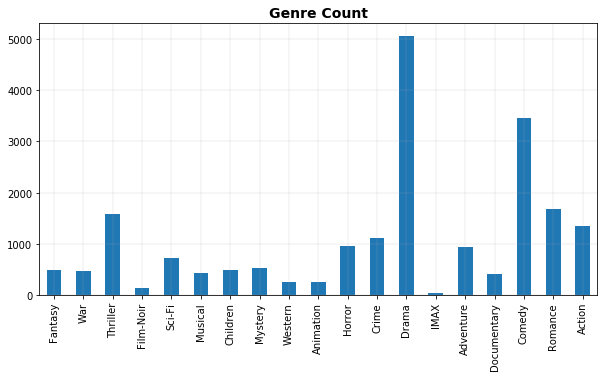

In [15]:
ax = sum_genres.plot.bar(figsize=(10,5))
ax.set_title('Genre Count', fontsize=14, fontweight='bold')
ax.grid(linewidth=0.2)

### analyze ratings

Dataset info: Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

In [16]:
rating_counts = ratings_data['rating'].value_counts()
rating_counts

4.0    2880
3.0    1901
5.0    1494
3.5    1236
4.5     873
2.0     666
2.5     491
1.0     233
1.5     141
0.5      85
Name: rating, dtype: int64

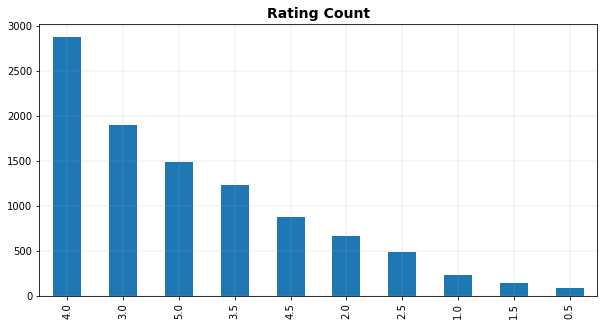

In [17]:
ax = rating_counts.plot.bar(figsize=(10,5))
ax.set_title('Rating Count', fontsize=14, fontweight='bold')
ax.grid(linewidth=0.2)

#### highest rated movies

In [18]:
movie_stats = movie_ratings_df.groupby('movie_title')['rating'].describe()
movie_stats.head()

,count,mean,std,min,25%,50%,75%,max
movie_title,,,,,,,,
'Round Midnight (1986),1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
"'burbs, The (1989)",1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
'night Mother (1986),1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
...And Justice for All (1979),1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
...tick... tick... tick... (1970),1.0,3.5,NaN,3.5,3.5,3.5,3.5,3.5


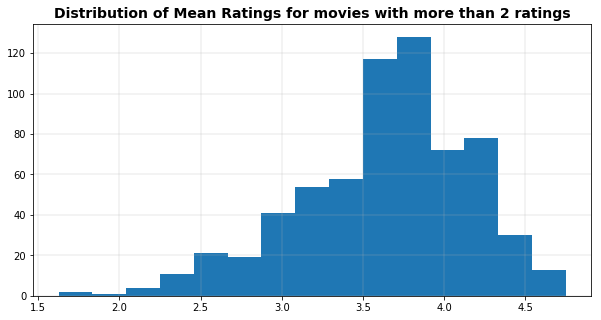

In [19]:
ax = movie_stats[movie_stats['count'] > 3]['mean'].hist(bins=15, figsize=(10,5))
ax.set_title('Distribution of Mean Ratings for movies with more than 2 ratings', fontsize=14, fontweight='bold')
ax.grid(linewidth=0.3)

In [20]:
#get best rated movies based on average rating:
best_movies = movie_stats[movie_stats['count'] > 5]['mean'].nlargest(3)
print('Best rated movies (based on mean rating): \n')
print(best_movies)

Best rated movies (based on mean rating): 

movie_title
Adventures of Robin Hood, The (1938)       4.750000
Ashes of Time (Dung che sai duk) (1994)    4.666667
Across the Sea of Time (1995)              4.562500
Name: mean, dtype: float64


In [21]:
#get devation of ratings for best movies:
mask = ((movie_stats['count'] > 5) & (movie_stats['mean'] > 4.5))

movie_stats[mask]['std']

movie_title
2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her) (1967)    0.522129
Across the Sea of Time (1995)                                               0.903861
Adventures of Robin Hood, The (1938)                                        0.462910
Ashes of Time (Dung che sai duk) (1994)                                     0.605530
Name: std, dtype: float64

In [22]:
movie_stats.filter(best_movies.index, axis=0)

,count,mean,std,min,25%,50%,75%,max
movie_title,,,,,,,,
"Adventures of Robin Hood, The (1938)",8.0,4.750000,0.462910,4.0,4.750,5.0,5.0,5.0
Ashes of Time (Dung che sai duk) (1994),6.0,4.666667,0.605530,3.5,4.625,5.0,5.0,5.0
Across the Sea of Time (1995),8.0,4.562500,0.903861,2.5,4.750,5.0,5.0,5.0


In [23]:
#movies with biggest number of ratings:
movie_stats['count'].nlargest(5)

movie_title
Ladybird Ladybird (1994)                     42.0
It Could Happen to You (1994)                37.0
Quiz Show (1994)                             37.0
Wooden Man's Bride, The (Yan shen) (1994)    37.0
Swimming with Sharks (1995)                  36.0
Name: count, dtype: float64

#### genre & ratings

In [24]:
#merge dfs to get ratings & genres
ratings_and_genre = pd.merge(ratings_data[['movieId','rating']], movies_data, on='movieId')
ratings_and_genre.head()

,movieId,rating,movie_title,genres,Fantasy,War,Thriller,Film-Noir,Sci-Fi,Musical,...,Animation,Horror,Crime,Drama,IMAX,Adventure,Documentary,Comedy,Romance,Action
0,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,296,4.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
#get most common genres:
most_common_genres = list(sum_genres.nlargest(10).index)

#create custom dict to store stats of genres:
genre_ratings_dict = {}
for genre in most_common_genres:
    mean_rating = ratings_and_genre[ratings_and_genre[genre] > 0]['rating'].mean()
    rating_count = ratings_and_genre[ratings_and_genre[genre] > 0]['rating'].count()
    genre_ratings_dict[genre] = [mean_rating,rating_count]
    
#create df:
genre_ratings_df = pd.DataFrame.from_dict(genre_ratings_dict)

#get final df:
genre_ratings_df = genre_ratings_df.transpose().reset_index() 

genre_ratings_df.columns = ['genre','mean_rating', 'rating_count']
genre_ratings_df.head()

,genre,mean_rating,rating_count
0,Drama,3.722635,3636.0
1,Comedy,3.499369,3169.0
2,Romance,3.601951,1589.0
3,Thriller,3.580058,2061.0
4,Action,3.519472,2388.0


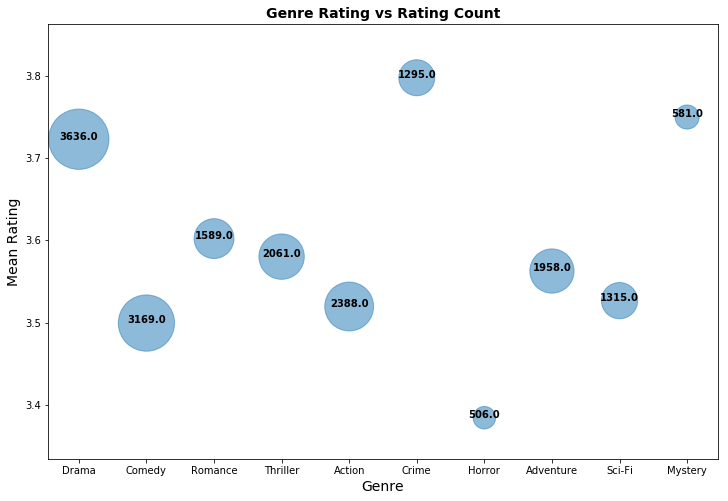

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter('genre', 'mean_rating', s='rating_count',alpha=0.5, data=genre_ratings_df)
ax.set_xlabel("Genre", size=14)
ax.set_ylabel("Mean Rating", size=14)
ax.set_title("Genre Rating vs Rating Count", size=14, fontweight = 'bold')
#For each point, we add a text inside the bubble
for line in range(0,genre_ratings_df.shape[0]):
     ax.text(genre_ratings_df.genre[line], genre_ratings_df.mean_rating[line], genre_ratings_df.rating_count[line], horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.show()

### analyze number of ratings per user

In [27]:
movie_ratings_df.groupby('userId')['movie_title'].unique()

userId
User_1     [Quiz Show (1994), Rent-a-Kid (1995), Relative...
User_10    [Jumanji (1995), Wings of Courage (1995), Guar...
User_11    [Murder in the First (1995), Speed (1994), Ser...
User_12    [Jumanji (1995), Grumpier Old Men (1995), Wait...
User_13    [Jumanji (1995), Money Train (1995), Wings of ...
                                 ...                        
User_73    [Jumanji (1995), Sabrina (1995), Cutthroat Isl...
User_74    [American President, The (1995), Addiction, Th...
User_75    [Jumanji (1995), Heat (1995), Sabrina (1995), ...
User_8     [Jumanji (1995), Waiting to Exhale (1995), Sab...
User_9     [Grumpier Old Men (1995), American President, ...
Name: movie_title, Length: 75, dtype: object

In [28]:
movie_ratings_df.groupby('userId').size()

userId
User_1      65
User_10     50
User_11     20
User_12    651
User_13    240
          ... 
User_73     39
User_74     22
User_75     61
User_8     155
User_9     178
Length: 75, dtype: int64

In [29]:
movie_ratings_df.groupby('userId').size().describe()

count     75.000000
mean     106.480000
std      140.880758
min        2.000000
25%       25.000000
50%       50.000000
75%      137.500000
max      813.000000
dtype: float64